In [ ]:
!pip install -r requirement

In [2]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.optim as optim


In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.conv(x)


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.downconv(x)


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upconv(x)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool =nn.Sequential(nn.AvgPool2d(kernel_size=7),
                                 nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pool(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.unflatten = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0),
            nn.BatchNorm2d(in_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.unflatten(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            DownConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            UpConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)

In [4]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.initial_conv = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.final_conv = ConvBlock(2*num_hiddens, num_hiddens)

        self.final_conv2 = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        x1 = self.initial_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)
        x4 = self.unflatten(x4)

        x5 = self.up1(torch.cat([x4, x3], dim=1))
        x6 = self.up2(torch.cat([x5, x2], dim=1))

        out = self.final_conv(torch.cat([x6, x1], dim=1))
        out = self.final_conv2(out)

        return out

In [5]:
def add_noise(images, sigma):
    noise = sigma * torch.randn_like(images)
    return images + noise

def plot_noising_process(images, sigma_values):
    fig, axs = plt.subplots(6, len(sigma_values), figsize=(15, 10))
    
    for j in range(6):  # Iterate over 6 rows (6 images)
        for i, sigma in enumerate(sigma_values):  # Iterate over columns (different noise levels)
            noisy_image = add_noise(images[j:j+1], sigma).squeeze().cpu().numpy()
            axs[j, i].imshow(noisy_image, cmap='gray')
            axs[j, i].set_title(f'σ = {sigma}' if j == 0 else '')  # Title only on the first row
            axs[j, i].axis('off')
    
    plt.tight_layout()
    plt.savefig("./image/noise_on_MNIST.png")

In [23]:
# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

model = UnconditionalUNet(in_channels=1, num_hiddens=128).to('cuda')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [24]:
from tqdm import tqdm
num_epochs = 5
sigma_train = 0.5 
train_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to('cuda')
        
        noisy_images = add_noise(images, sigma_train).to('cuda')
        
        outputs = model(noisy_images)
        
        loss = criterion(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_losses.append(loss.item())
    
    avg_loss = running_loss / len(train_loader)
    #train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
    if epoch == 0:
        model_path = 'unet_denoiser_epoch1.pth'
        torch.save(model.state_dict(), model_path)
        print(f'Model weights after epoch 1 saved to {model_path}')

 20%|██        | 1/5 [00:25<01:41, 25.32s/it]

Epoch [1/5], Loss: 0.0469
Model weights after epoch 1 saved to unet_denoiser_epoch1.pth


 40%|████      | 2/5 [00:50<01:15, 25.32s/it]

Epoch [2/5], Loss: 0.0155


 60%|██████    | 3/5 [01:15<00:50, 25.32s/it]

Epoch [3/5], Loss: 0.0141


 80%|████████  | 4/5 [01:41<00:25, 25.33s/it]

Epoch [4/5], Loss: 0.0133


100%|██████████| 5/5 [02:06<00:00, 25.34s/it]

Epoch [5/5], Loss: 0.0129


In [36]:
model_path = 'unet_denoiser_final.pth'
torch.save(model.state_dict(), model_path)
print(f'Model weights saved to {model_path}')

Model weights saved to unet_denoiser_final.pth


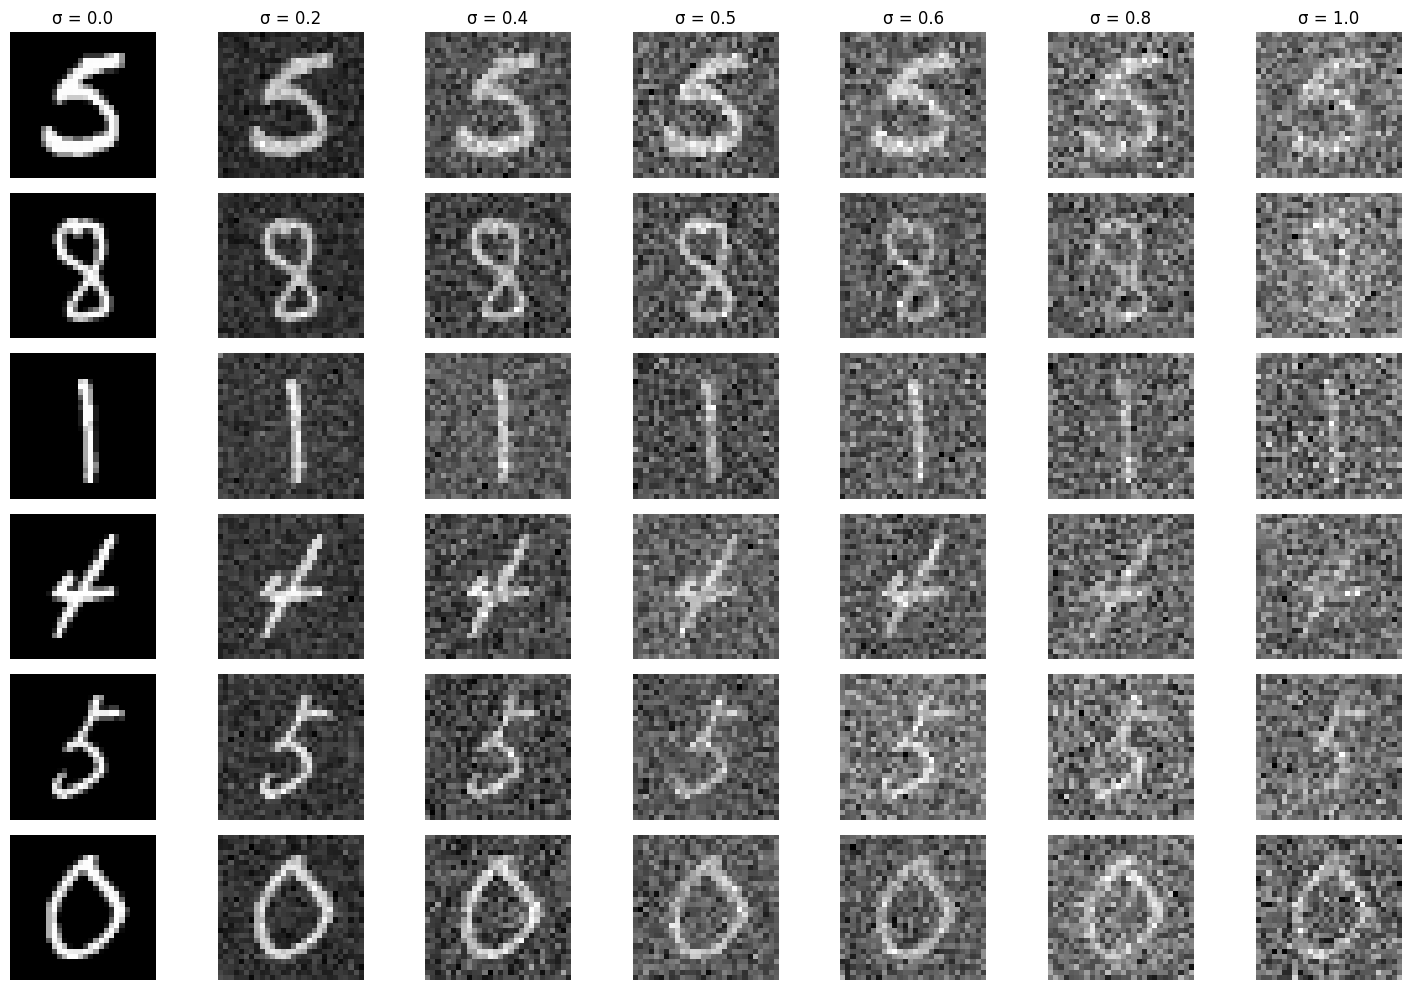

In [29]:

sample_images, _ = next(iter(train_loader))
plot_noising_process(sample_images, sigma_values=[0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0])


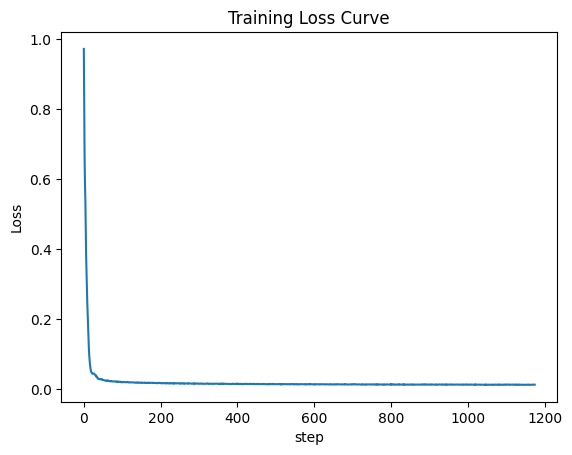

In [30]:
plt.figure()
plt.plot(train_losses)
plt.xlabel('step')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.savefig("./image/loss1.png")

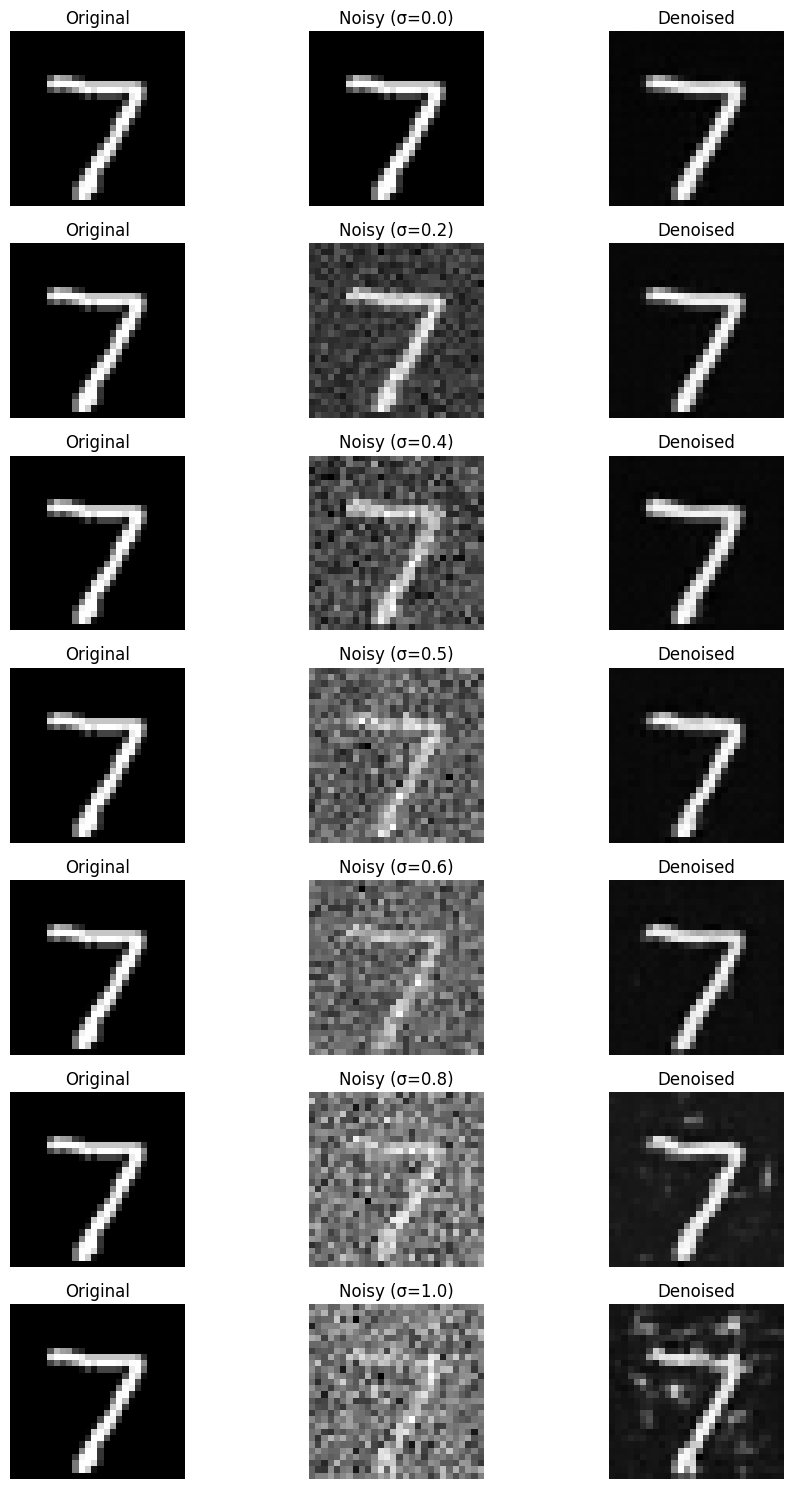

In [35]:
model.eval()
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

sigma_test_values = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
test_samples = []

for sigma in sigma_test_values:
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to('cuda')
    noisy_test_images = add_noise(test_images, sigma).to('cuda')
    
    with torch.no_grad():
        denoised_images = model(noisy_test_images)
    
    test_samples.append((test_images[0], noisy_test_images[0], denoised_images[0]))

fig, axs = plt.subplots(len(sigma_test_values), 3, figsize=(10, 15))
for i, (original, noisy, denoised) in enumerate(test_samples):
    axs[i, 0].imshow(original.squeeze().cpu().numpy(), cmap='gray')
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(noisy.squeeze().cpu().numpy(), cmap='gray')
    axs[i, 1].set_title(f'Noisy (σ={sigma_test_values[i]})')
    axs[i, 1].axis('off')
    
    axs[i, 2].imshow(denoised.squeeze().cpu().numpy(), cmap='gray')
    axs[i, 2].set_title('Denoised')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.savefig("./image/denoise1.png") 

In [38]:
def display_test_results(model_paths, sigma=0.5, num_samples=3,epoch_name='1st Epoch'):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
    
    models = []
    epoch_titles = [epoch_name]
    for path in model_paths:
        model = UnconditionalUNet(in_channels=1, num_hiddens=128).to('cuda')
        model.load_state_dict(torch.load(path))
        model.eval() 
        models.append(model)
    
    fig, axs = plt.subplots(num_samples, 3 * len(models), figsize=(15, num_samples * 4))
    for model_idx, title in enumerate(epoch_titles):
        col = model_idx * 3
        axs[0, col].set_title(f'{title} - Input', fontsize=12)
        axs[0, col + 1].set_title(f'{title} - Noisy (σ={sigma})', fontsize=12)
        axs[0, col + 2].set_title(f'{title} - Output', fontsize=12)

    for sample_idx in range(num_samples):
        test_images, _ = next(iter(test_loader))
        test_images = test_images.to('cuda')
        
        noisy_images = add_noise(test_images, sigma).to('cuda')
        
        for model_idx, model in enumerate(models):
            with torch.no_grad():
                denoised_images = model(noisy_images)
            
            axs[sample_idx, model_idx * 3].imshow(test_images[0].squeeze().cpu().numpy(), cmap='gray')
            axs[sample_idx, model_idx * 3].axis('off')
            
            axs[sample_idx, model_idx * 3 + 1].imshow(noisy_images[0].squeeze().cpu().numpy(), cmap='gray')
            axs[sample_idx, model_idx * 3 + 1].axis('off')
            
            axs[sample_idx, model_idx * 3 + 2].imshow(denoised_images[0].squeeze().cpu().numpy(), cmap='gray')
            axs[sample_idx, model_idx * 3 + 2].axis('off')
    
    plt.tight_layout()
    plt.savefig("./image/{}.png".format(epoch_name))

/tmp/ipykernel_54890/2496067001.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


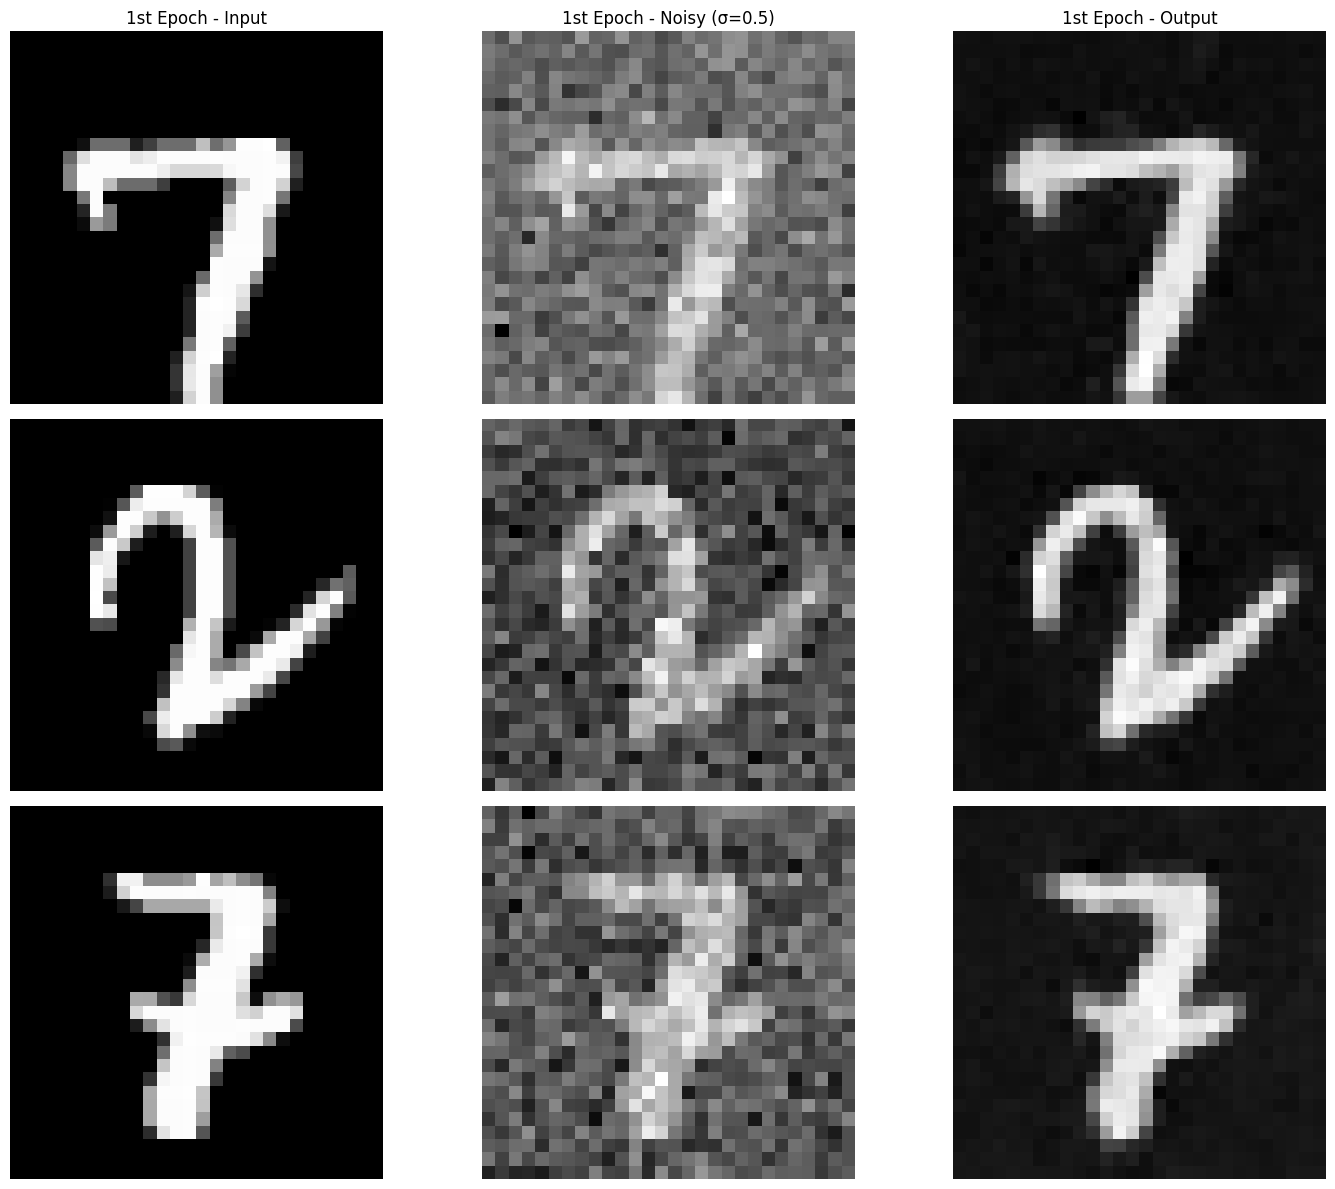

In [39]:
model_paths = ['unet_denoiser_epoch1.pth']
display_test_results(model_paths, sigma=0.5, num_samples=3,epoch_name='1st Epoch')

/tmp/ipykernel_54890/2496067001.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


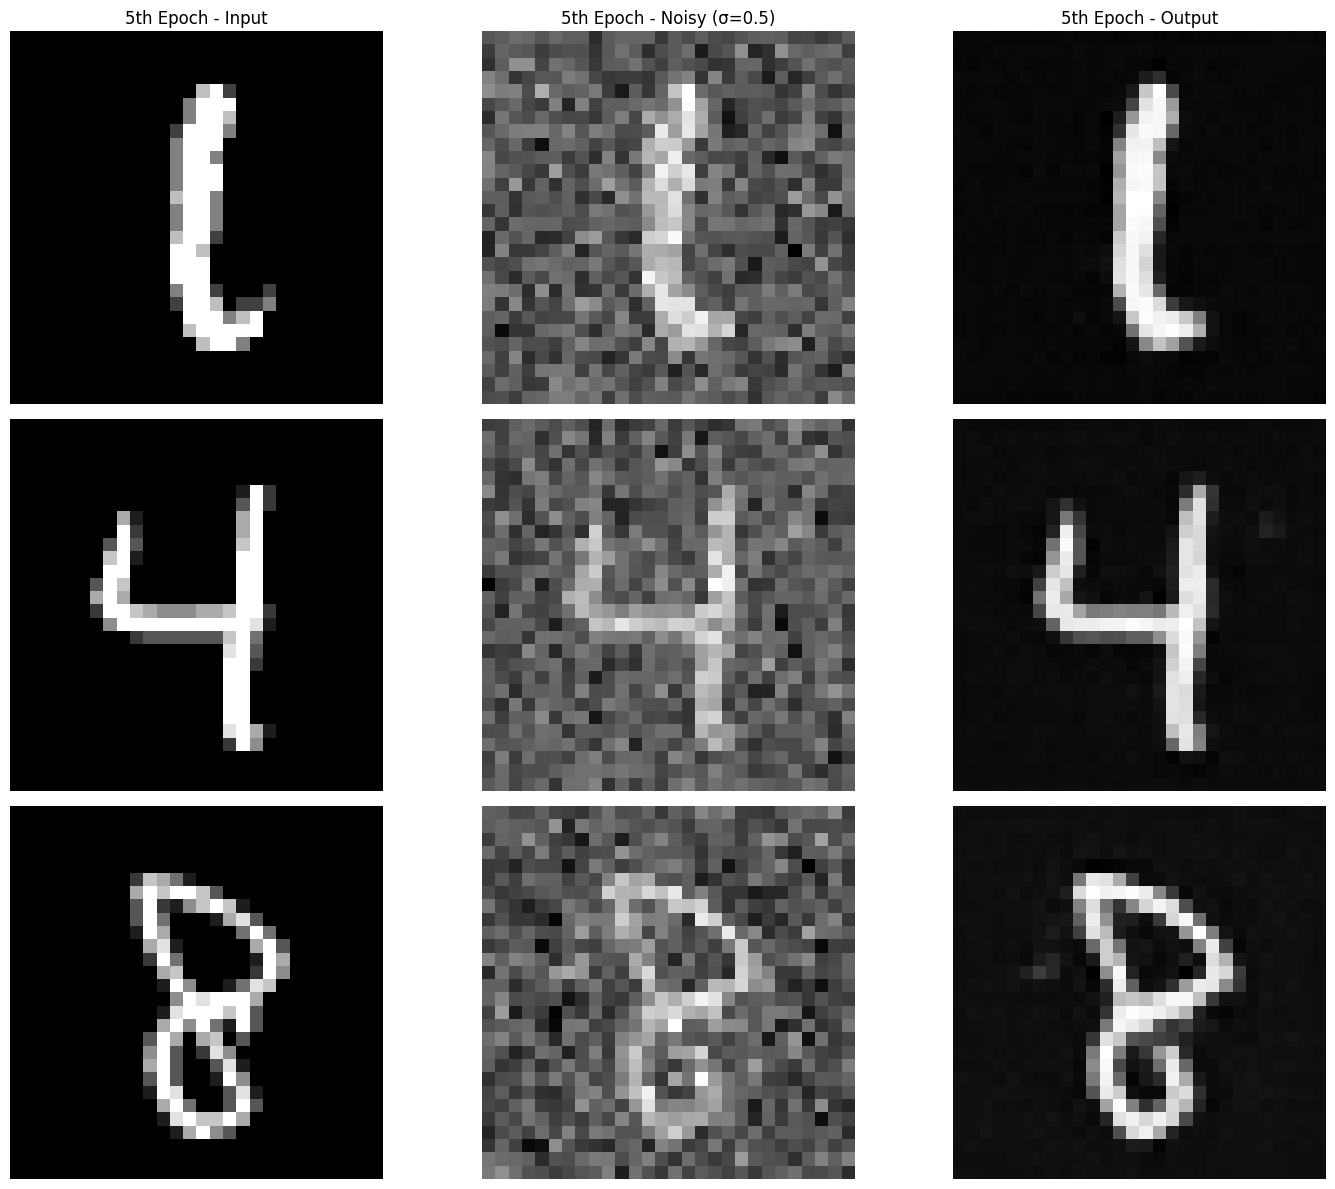

In [40]:
display_test_results(['unet_denoiser_final.pth'], sigma=0.5, num_samples=3,epoch_name='5th Epoch')

In [6]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)

In [7]:
class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.initial_conv = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.fc1_t = FCBlock(1, num_hiddens * 2) 
        self.fc2_t = FCBlock(1, num_hiddens)  

        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.final_conv = ConvBlock(2 * num_hiddens, num_hiddens)
        self.final_conv2 = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        batch_size = x.shape[0]
        x1 = self.initial_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)
        
        x4 = self.unflatten(x4)
        t1 = self.fc1_t(t.unsqueeze(-1)).reshape(batch_size,-1,1,1)
        x4 = x4 + t1

        x5 = self.up1(torch.cat([x4, x3], dim=1))
        t2 = self.fc2_t(t.unsqueeze(-1)).reshape(batch_size,-1,1,1)
        x5 = x5 + t2
        x6 = self.up2(torch.cat([x5, x2], dim=1))

        out = self.final_conv(torch.cat([x6, x1], dim=1))
        out = self.final_conv2(out)

        return out

In [8]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    
    # Create a linear schedule of betas
    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    alphas_bars_prev = nn.functional.pad(alpha_bars[:-1], (1, 0), value=1.0)
    
    return {
        "betas": betas,
        "alphas": alphas,
        "alpha_bars": alpha_bars,
        "alpha_bars_pre": alphas_bars_prev
    }

In [9]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    device=x_0.device
    batch_size = x_0.shape[0]
    noise = torch.randn_like(x_0).to(device)
    t = torch.randint(0, num_ts, (batch_size,)).long()
    alpha_bar_t = ddpm_schedule["alpha_bars"][t].reshape(-1, 1, 1, 1).to(device)
    xt = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    
    # Pass through UNet
    t_tensor = (t / num_ts).to(device)
    epsilon_pred = unet(xt, t_tensor)
    
    # Compute L2 loss
    loss = nn.functional.mse_loss(epsilon_pred, noise)
    
    return loss

In [10]:
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    torch.manual_seed(seed)
    x_t = torch.randn((1, 1, *img_wh), device='cuda')
    
    for t in reversed(range(0, num_ts)):
        t_tensor = torch.full((1,), t / num_ts, device='cuda')
        epsilon_pred = unet(x_t, t_tensor)
        
        alpha_bar_t = ddpm_schedule["alpha_bars"][t]
        alpha_bar_prev = ddpm_schedule["alpha_bars_pre"][t]
        beta_t = ddpm_schedule["betas"][t]
        alpha_t = ddpm_schedule["alphas"][t]
        sqrt_recip_alpha_t = 1 / torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        sigma_t = torch.sqrt((1-alpha_bar_prev)/(1-alpha_bar_t) * beta_t)
        
        x_t_minus_1 = (
            sqrt_recip_alpha_t * (x_t - (1 - alpha_t) / sqrt_one_minus_alpha_bar_t * epsilon_pred)
        )
        
        if t > 0:
            noise = torch.randn_like(x_t)
            x_t_minus_1 += sigma_t * noise
        x_t = x_t_minus_1
    
    return x_t

In [11]:
import imageio
def ddpm_sample_with_gif(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Modified DDPM sampling function to create a GIF.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.
        gif_path: str, path to save the GIF.

    Returns:
        (N, C, H, W) final sample.
    """
    torch.manual_seed(seed)
    images = [] 

    x_t = torch.randn((1, 1, *img_wh), device='cuda')
    
    for t in reversed(range(0, num_ts)):
        t_tensor = torch.full((1,), t / num_ts, device='cuda')
        epsilon_pred = unet(x_t, t_tensor)
        
        alpha_bar_t = ddpm_schedule["alpha_bars"][t]
        alpha_bar_prev = ddpm_schedule["alpha_bars_pre"][t]
        beta_t = ddpm_schedule["betas"][t]
        alpha_t = ddpm_schedule["alphas"][t]
        sqrt_recip_alpha_t = 1 / torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        sigma_t = torch.sqrt((1-alpha_bar_prev)/(1-alpha_bar_t) * beta_t)
        
        x_t_minus_1 = (
            sqrt_recip_alpha_t * (x_t - (1 - alpha_t) / sqrt_one_minus_alpha_bar_t * epsilon_pred)
        )
        
        if t > 0:
            noise = torch.randn_like(x_t)
            x_t_minus_1 += sigma_t * noise
        x_t = x_t_minus_1
        
        if t % 10 == 0:
            img = x_t.squeeze().detach().cpu().numpy()
            img = (img - img.min()) / (img.max() - img.min()) * 255 
            img = img.astype('uint8')
            images.append(img)
    return images

In [12]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )
    def sample_git(
        self,
        img_wh,
        seed,
    ):
        return ddpm_sample_with_gif(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

In [47]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
unet = TimeConditionalUNet(in_channels=1, num_hiddens=64).to('cuda')
ddpm_model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300).to('cuda')

optimizer = optim.Adam(ddpm_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1.0 / 20)) 
num_epochs = 20
losses = []

In [48]:
from tqdm import tqdm
# Training loop
for epoch in tqdm(range(num_epochs)):
    ddpm_model.train()
    running_loss = 0.0
    
    for batch_idx, (x_0, _) in enumerate(train_loader):
        x_0 = x_0.to('cuda')
        loss = ddpm_model(x_0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        losses.append(loss.item())
        
    scheduler.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


    if epoch + 1 in [1, 5, 10, 15, 20]:
        model_path = f'TimeConditionalUNet_epoch_{epoch+1}.pth'
        torch.save(ddpm_model.state_dict(), model_path)
        print(f'Model weights saved at {model_path}')

  5%|▌         | 1/20 [00:15<04:55, 15.54s/it]

Epoch [1/20], Loss: 0.0955
Model weights saved at TimeConditionalUNet_epoch_1.pth


 10%|█         | 2/20 [00:30<04:37, 15.44s/it]

Epoch [2/20], Loss: 0.0611


 15%|█▌        | 3/20 [00:46<04:21, 15.39s/it]

Epoch [3/20], Loss: 0.0565


 20%|██        | 4/20 [01:01<04:05, 15.36s/it]

Epoch [4/20], Loss: 0.0535


 25%|██▌       | 5/20 [01:16<03:50, 15.35s/it]

Epoch [5/20], Loss: 0.0510
Model weights saved at TimeConditionalUNet_epoch_5.pth


 30%|███       | 6/20 [01:32<03:34, 15.31s/it]

Epoch [6/20], Loss: 0.0491


 35%|███▌      | 7/20 [01:47<03:19, 15.32s/it]

Epoch [7/20], Loss: 0.0479


 40%|████      | 8/20 [02:02<03:03, 15.32s/it]

Epoch [8/20], Loss: 0.0465


 45%|████▌     | 9/20 [02:18<02:48, 15.32s/it]

Epoch [9/20], Loss: 0.0461


 50%|█████     | 10/20 [02:33<02:33, 15.33s/it]

Epoch [10/20], Loss: 0.0454
Model weights saved at TimeConditionalUNet_epoch_10.pth


 55%|█████▌    | 11/20 [02:48<02:17, 15.33s/it]

Epoch [11/20], Loss: 0.0446


 60%|██████    | 12/20 [03:04<02:02, 15.33s/it]

Epoch [12/20], Loss: 0.0439


 65%|██████▌   | 13/20 [03:19<01:47, 15.32s/it]

Epoch [13/20], Loss: 0.0434


 70%|███████   | 14/20 [03:34<01:31, 15.30s/it]

Epoch [14/20], Loss: 0.0427


 75%|███████▌  | 15/20 [03:49<01:16, 15.31s/it]

Epoch [15/20], Loss: 0.0422
Model weights saved at TimeConditionalUNet_epoch_15.pth


 80%|████████  | 16/20 [04:05<01:01, 15.29s/it]

Epoch [16/20], Loss: 0.0422


 85%|████████▌ | 17/20 [04:20<00:45, 15.27s/it]

Epoch [17/20], Loss: 0.0418


 90%|█████████ | 18/20 [04:35<00:30, 15.28s/it]

Epoch [18/20], Loss: 0.0414


 95%|█████████▌| 19/20 [04:51<00:15, 15.31s/it]

Epoch [19/20], Loss: 0.0415


100%|██████████| 20/20 [05:06<00:00, 15.33s/it]

Epoch [20/20], Loss: 0.0411
Model weights saved at TimeConditionalUNet_epoch_20.pth


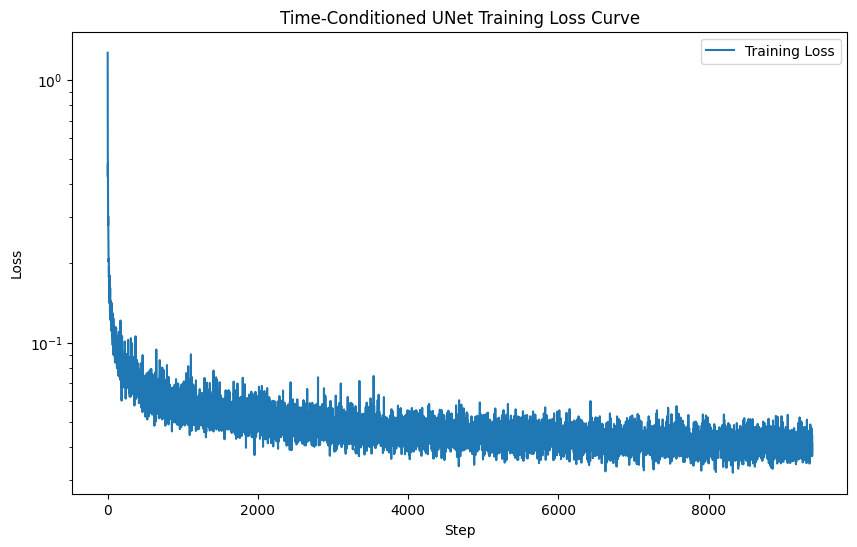

In [53]:
# Plot training loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Time-Conditioned UNet Training Loss Curve')
plt.legend()
plt.savefig("./image/loss2.png")

In [13]:
model_epoch5 = TimeConditionalUNet(in_channels=1, num_hiddens=64).to('cuda')
DDPM_5 = DDPM(model_epoch5, betas=(1e-4, 0.02), num_ts=300).to('cuda')
model_epoch20 = TimeConditionalUNet(in_channels=1, num_hiddens=64).to('cuda')
DDPM_20 = DDPM(model_epoch20, betas=(1e-4, 0.02), num_ts=300).to('cuda')
msg1 = DDPM_5.load_state_dict(torch.load('/home/shanlins/diffusion/TimeConditionalUNet_epoch_5.pth'))
msg2 = DDPM_20.load_state_dict(torch.load('/home/shanlins/diffusion/TimeConditionalUNet_epoch_20.pth'))
DDPM_5.eval()
DDPM_20.eval()

/tmp/ipykernel_58548/2941445641.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  msg1 = DDPM_5.load_state_dict(torch.load('/home/shanlins/diffusion/TimeConditionalUNet_ep

DDPM(
  (unet): TimeConditionalUNet(
    (initial_conv): ConvBlock(
      (block): Sequential(
        (0): Conv(
          (conv): Sequential(
            (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
          )
        )
        (1): Conv(
          (conv): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
          )
        )
      )
    )
    (down1): DownBlock(
      (block): Sequential(
        (0): DownConv(
          (downconv): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): G

In [14]:
print("Generating GIF for epoch 5:")
all_gif_imgs = []
for i in range(40):
    img = DDPM_5.sample_git(img_wh=(28, 28), seed=i)
    all_gif_imgs.append(img)
grid_size = (4, 10)  
num_frames_per_sample = len(all_gif_imgs[0])  
gif_frames = []  


for frame_idx in range(num_frames_per_sample):
    processed_images = []
    for img_list in all_gif_imgs:
        frame = img_list[frame_idx]  
        frame = (frame - frame.min()) / (frame.max() - frame.min()) * 255
        frame = frame.astype('uint8')
        processed_images.append(frame)

    grid_images = []
    for i in range(grid_size[0]):  
        row_images = processed_images[i * grid_size[1]:(i + 1) * grid_size[1]]
        grid_images.append(np.hstack(row_images))  
    final_image = np.vstack(grid_images)  

    gif_frames.append(final_image)
imageio.mimsave('./image/DDPM_5_full_grid_sample.gif', gif_frames, fps=10)
print('Full grid GIF saved as DDPM_5_full_grid_sample.gif')

Generating GIF for epoch 5:
Full grid GIF saved as DDPM_5_full_grid_sample.gif


In [15]:
print("Generating GIF for epoch 20:")
all_gif_imgs = []
for i in range(40):
    img = DDPM_20.sample_git(img_wh=(28, 28), seed=i)
    all_gif_imgs.append(img)
grid_size = (4, 10)  
num_frames_per_sample = len(all_gif_imgs[0])  
gif_frames = []  


for frame_idx in range(num_frames_per_sample):
    processed_images = []
    for img_list in all_gif_imgs:
        frame = img_list[frame_idx]  
        frame = (frame - frame.min()) / (frame.max() - frame.min()) * 255
        frame = frame.astype('uint8')
        processed_images.append(frame)

    grid_images = []
    for i in range(grid_size[0]):  
        row_images = processed_images[i * grid_size[1]:(i + 1) * grid_size[1]]
        grid_images.append(np.hstack(row_images))  
    final_image = np.vstack(grid_images)  

    gif_frames.append(final_image)
imageio.mimsave('./image/DDPM_20_full_grid_sample.gif', gif_frames, fps=10)
print('Full grid GIF saved as DDPM_20_full_grid_sample.gif')

Generating GIF for epoch 20:
Full grid GIF saved as DDPM_20_full_grid_sample.gif


In [16]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.initial_conv = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)

        self.fc1_c = FCBlock(num_classes, num_hiddens * 2)
        self.fc2_c = FCBlock(num_classes, num_hiddens)

        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.final_conv = ConvBlock(2 * num_hiddens, num_hiddens)
        self.final_conv2 = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor (class labels).
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        batch_size = x.shape[0]

        

        x1 = self.initial_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)

        t1 = self.fc1_t(t.unsqueeze(-1)).reshape(batch_size, -1, 1, 1)
        t2 = self.fc2_t(t.unsqueeze(-1)).reshape(batch_size, -1, 1, 1)

        c1 = self.fc1_c(c).reshape(batch_size, -1, 1, 1)
        c2 = self.fc2_c(c).reshape(batch_size, -1, 1, 1)
        if mask is not None:
            c1 = c1 * mask.view(batch_size, 1, 1, 1)
            c2 = c2 * mask.view(batch_size, 1, 1, 1)

        
        x4 = self.unflatten(x4)
        x4 = c1 * x4 + t1

        x5 = self.up1(torch.cat([x4, x3], dim=1))
        x5 = c2 * x5 + t2

        x6 = self.up2(torch.cat([x5, x2], dim=1))

        out = self.final_conv(torch.cat([x6, x1], dim=1))
        out = self.final_conv2(out)

        return out

In [17]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict containing diffusion schedule parameters.
        x_0: (N, C, H, W) input tensor (original data).
        c: (N,) int64 condition tensor (class labels).
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        Tensor representing the diffusion loss.
    """
    alpha_bars = ddpm_schedule["alpha_bars"].to(x_0.device)
    criterion = nn.MSELoss()
    batch_size = x_0.size(0)

    t = torch.randint(0, num_ts, (batch_size,), device=x_0.device).long()
    noise = torch.randn_like(x_0)

    alpha_bar_t = alpha_bars[t].reshape(batch_size, 1, 1, 1)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    c_one_hot = torch.nn.functional.one_hot(c, num_classes=10).float().to(x_0.device)
    if torch.rand(1).item() < p_uncond:
        mask = torch.zeros(batch_size, device=x_0.device)
    else:
        mask = None
    predicted_noise = unet(x_t, c_one_hot, t.float() / num_ts, mask)

    loss = criterion(predicted_noise, noise)

    return loss

In [18]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict containing diffusion schedule parameters.
        c: (N,) int64 condition tensor. Only for class-conditional generation.
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale for classifier-free guidance.
        seed: int, random seed for reproducibility.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches for visualization (optional).
    """
    torch.manual_seed(seed)

    alpha_bars = ddpm_schedule["alpha_bars"]
    alphas = ddpm_schedule["alphas"]
    betas = ddpm_schedule["betas"]
    batch_size = c.size(0)
    x_t = torch.randn((batch_size, 1, *img_wh)).to("cuda")

    animation_cache = []

    for t in reversed(range(0, num_ts)):
        t_tensor = torch.tensor([t / num_ts]).repeat(batch_size).to('cuda')
        c_one_hot = torch.nn.functional.one_hot(c, num_classes=10).float().to('cuda')
        uncond_mask = torch.zeros(batch_size).to("cuda")
        epsilon_uncond = unet(x_t, c_one_hot, t_tensor, uncond_mask)

        epsilon_cond = unet(x_t, c_one_hot, t_tensor)

        epsilon_t = epsilon_uncond + guidance_scale*(epsilon_cond-epsilon_uncond)

        alpha_bar_t = alpha_bars[t]
        alpha_t = alphas[t]
        alpha_bar_t_1 = alpha_bars[t - 1] if t > 1 else 1.0
        sqrt_recip_alpha_t = 1 / torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        beta_t = betas[t]
        sigma_t = torch.sqrt((1 - alpha_bar_t_1) / (1 - alpha_bar_t)) * torch.sqrt(beta_t)
        
        mean = sqrt_recip_alpha_t * (x_t - (1 - alpha_t) / sqrt_one_minus_alpha_bar_t * epsilon_t)
        
        if t > 1:
            x_t = mean + sigma_t * torch.randn_like(x_t)
        else:
            x_t = mean 
        if t % 10 == 0:
            animation_cache.append(x_t.clone().squeeze().detach().cpu().numpy())

    return x_t, animation_cache

In [19]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor,c) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x,c,self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        c,
        guidance_scale: float =5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule,c, img_wh, self.num_ts,guidance_scale, seed
        )

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
unet = ClassConditionalUNet(in_channels=1, num_classes=10,num_hiddens=64).to('cuda')
ddpm_model = DDPM(unet=unet, betas=(1e-4, 0.02), num_ts=300).to('cuda')

optimizer = optim.Adam(ddpm_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1.0 / 20)) 
num_epochs = 20
losses = []

In [21]:
from tqdm import tqdm

# Training loop for ClassConditionalUNet
for epoch in tqdm(range(num_epochs)):
    ddpm_model.train()
    running_loss = 0.0
    
    for batch_idx, (x_0, labels) in enumerate(train_loader):
        x_0 = x_0.to('cuda')
        labels = labels.to('cuda')

        # Compute the forward pass using the DDPM forward function
        loss = ddpm_model(x_0,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        losses.append(loss.item())
        
    scheduler.step()  
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')
    if epoch + 1 in [1, 5, 10, 15, 20]:
        model_path = f'ClassConditionalUNet_epoch_{epoch+1}.pth'
        torch.save(ddpm_model.state_dict(), model_path)
        print(f'Model weights saved at {model_path}')

  5%|▌         | 1/20 [00:15<04:56, 15.62s/it]

Epoch [1/20], Loss: 0.0901
Model weights saved at ClassConditionalUNet_epoch_1.pth


 10%|█         | 2/20 [00:30<04:37, 15.44s/it]

Epoch [2/20], Loss: 0.0595


 15%|█▌        | 3/20 [00:46<04:20, 15.34s/it]

Epoch [3/20], Loss: 0.0536


 20%|██        | 4/20 [01:01<04:04, 15.30s/it]

Epoch [4/20], Loss: 0.0504


 25%|██▌       | 5/20 [01:16<03:50, 15.36s/it]

Epoch [5/20], Loss: 0.0483
Model weights saved at ClassConditionalUNet_epoch_5.pth


 30%|███       | 6/20 [01:32<03:35, 15.41s/it]

Epoch [6/20], Loss: 0.0464


 35%|███▌      | 7/20 [01:47<03:20, 15.45s/it]

Epoch [7/20], Loss: 0.0453


 40%|████      | 8/20 [02:03<03:04, 15.41s/it]

Epoch [8/20], Loss: 0.0445


 45%|████▌     | 9/20 [02:18<02:49, 15.40s/it]

Epoch [9/20], Loss: 0.0435


 50%|█████     | 10/20 [02:33<02:33, 15.38s/it]

Epoch [10/20], Loss: 0.0427
Model weights saved at ClassConditionalUNet_epoch_10.pth


 55%|█████▌    | 11/20 [02:49<02:18, 15.37s/it]

Epoch [11/20], Loss: 0.0426


 60%|██████    | 12/20 [03:04<02:03, 15.38s/it]

Epoch [12/20], Loss: 0.0422


 65%|██████▌   | 13/20 [03:20<01:47, 15.39s/it]

Epoch [13/20], Loss: 0.0415


 70%|███████   | 14/20 [03:35<01:32, 15.37s/it]

Epoch [14/20], Loss: 0.0413


 75%|███████▌  | 15/20 [03:50<01:16, 15.38s/it]

Epoch [15/20], Loss: 0.0408
Model weights saved at ClassConditionalUNet_epoch_15.pth


 80%|████████  | 16/20 [04:06<01:01, 15.35s/it]

Epoch [16/20], Loss: 0.0407


 85%|████████▌ | 17/20 [04:21<00:46, 15.35s/it]

Epoch [17/20], Loss: 0.0404


 90%|█████████ | 18/20 [04:36<00:30, 15.34s/it]

Epoch [18/20], Loss: 0.0398


 95%|█████████▌| 19/20 [04:51<00:15, 15.31s/it]

Epoch [19/20], Loss: 0.0401


100%|██████████| 20/20 [05:07<00:00, 15.36s/it]

Epoch [20/20], Loss: 0.0399
Model weights saved at ClassConditionalUNet_epoch_20.pth


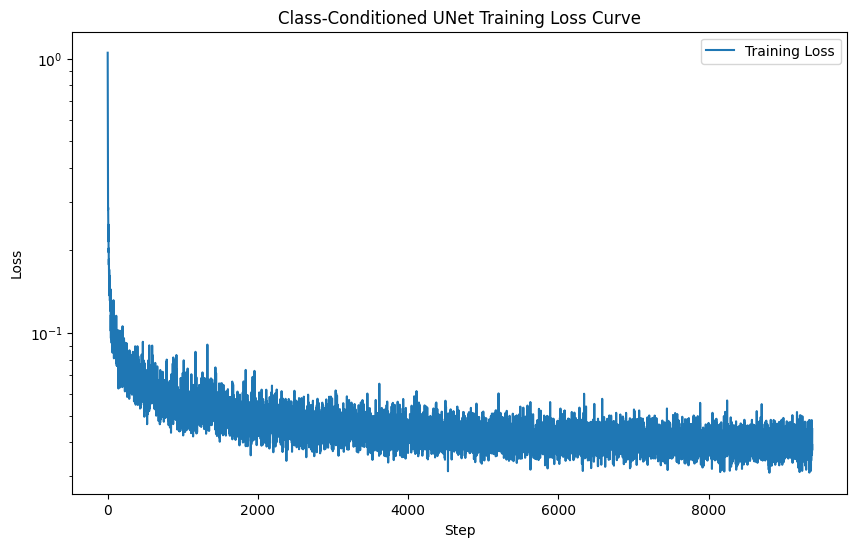

In [22]:
# Plot training loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Class-Conditioned UNet Training Loss Curve')
plt.legend()
plt.savefig('./image/loss3.png')

In [23]:
model_epoch5 =ClassConditionalUNet(in_channels=1,num_classes=10, num_hiddens=64).to('cuda')
DDPM_5 = DDPM(model_epoch5, betas=(1e-4, 0.02), num_ts=300).to('cuda')
model_epoch20 = ClassConditionalUNet(in_channels=1,num_classes=10, num_hiddens=64).to('cuda')
DDPM_20 = DDPM(model_epoch20, betas=(1e-4, 0.02), num_ts=300).to('cuda')
msg1 = DDPM_5.load_state_dict(torch.load('/home/shanlins/diffusion/ClassConditionalUNet_epoch_5.pth'))
msg2 = DDPM_20.load_state_dict(torch.load('/home/shanlins/diffusion/ClassConditionalUNet_epoch_20.pth'))
DDPM_5.eval()
DDPM_20.eval()

/tmp/ipykernel_58548/768159498.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  msg1 = DDPM_5.load_state_dict(torch.load('/home/shanlins/diffusion/ClassConditionalUNet_ep

DDPM(
  (unet): ClassConditionalUNet(
    (initial_conv): ConvBlock(
      (block): Sequential(
        (0): Conv(
          (conv): Sequential(
            (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
          )
        )
        (1): Conv(
          (conv): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
          )
        )
      )
    )
    (down1): DownBlock(
      (block): Sequential(
        (0): DownConv(
          (downconv): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): 

In [24]:
all_gif_imgs = []
for i in range(4):
    for j in range(10):
        c = torch.tensor([j])
        img,imgs = DDPM_5.sample(img_wh=(28, 28),c=c, seed=i)
        all_gif_imgs.append(imgs)
grid_size = (4, 10)  
num_frames_per_sample = len(all_gif_imgs[0])  
gif_frames = []  


for frame_idx in range(num_frames_per_sample):
    processed_images = []
    for img_list in all_gif_imgs:
        frame = img_list[frame_idx]  
        frame = (frame - frame.min()) / (frame.max() - frame.min()) * 255
        frame = frame.astype('uint8')
        processed_images.append(frame)

    grid_images = []
    for i in range(grid_size[0]):  
        row_images = processed_images[i * grid_size[1]:(i + 1) * grid_size[1]]
        grid_images.append(np.hstack(row_images))  
    final_image = np.vstack(grid_images)  

    gif_frames.append(final_image)
imageio.mimsave('./image/DDPM_5_class_grid_sample.gif', gif_frames, fps=10)
print('Full grid GIF saved as DDPM_5_class_grid_sample.gif')

Full grid GIF saved as DDPM_5_class_grid_sample.gif


In [25]:
all_gif_imgs = []
for i in range(4):
    for j in range(10):
        c = torch.tensor([j])
        img,imgs = DDPM_20.sample(img_wh=(28, 28),c=c, seed=i)
        all_gif_imgs.append(imgs)
grid_size = (4, 10)  
num_frames_per_sample = len(all_gif_imgs[0])  
gif_frames = []  


for frame_idx in range(num_frames_per_sample):
    processed_images = []
    for img_list in all_gif_imgs:
        frame = img_list[frame_idx]  
        frame = (frame - frame.min()) / (frame.max() - frame.min()) * 255
        frame = frame.astype('uint8')
        processed_images.append(frame)

    grid_images = []
    for i in range(grid_size[0]):  
        row_images = processed_images[i * grid_size[1]:(i + 1) * grid_size[1]]
        grid_images.append(np.hstack(row_images))  
    final_image = np.vstack(grid_images)  

    gif_frames.append(final_image)
imageio.mimsave('./image/DDPM_20_class_grid_sample.gif', gif_frames, fps=10)
print('Full grid GIF saved as DDPM_20_class_grid_sample.gif')

Full grid GIF saved as DDPM_20_class_grid_sample.gif
